Task statement:
Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

We need to predict two values, rougher concentrate recovery and final concentrate recovery, and evaluate model's performance using a custom formula using sMAPE for rougher and final recovery.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
# Warning filters
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Prepare the Data

### Data Exploration

In [3]:
# Import data from csv files
try:
    df_recovery_full = pd.read_csv('./gold_recovery_full.csv')
    df_recovery_train = pd.read_csv('./gold_recovery_train.csv')
    df_recovery_test = pd.read_csv('./gold_recovery_test.csv')
except:
    print("File(s) not found, please check file path(s) are correct")

In [4]:
df_list = [df_recovery_full,df_recovery_train,df_recovery_test]
for df in df_list:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Rougher Output Recovery Calculation

In [5]:
C = "rougher.output.concentrate_au"
F = "rougher.input.feed_au"
T = "rougher.output.tail_au"
df_recovery_train["rougher.output.recovery_calc"] = 100 * (df_recovery_train[C] * (df_recovery_train[F] - df_recovery_train[T])) / (df_recovery_train[F] * (df_recovery_train[C] - df_recovery_train[T]))

df_rougher_output_recovery = df_recovery_train[['rougher.output.recovery', 'rougher.output.recovery_calc']]

df_recovery_train[df_recovery_train['rougher.output.recovery'].isna()]

df_recovery_train[df_recovery_train['rougher.output.recovery_calc'].isna()]

# Remove missing values from df_recovery

df_rougher_output_recovery = df_rougher_output_recovery.dropna()

mae = mean_absolute_error(df_rougher_output_recovery['rougher.output.recovery'], df_rougher_output_recovery['rougher.output.recovery_calc'])

print("Mean Absolute Error:", mae)

# Drop rougher.output.recovery_calc as its no longer needed
df_recovery_train.drop('rougher.output.recovery_calc', axis=1, inplace=True)

Mean Absolute Error: 1.0724115653039479e-14


MAE is extremely small, so the rougher output recovery in the training set is correct.

### Full vs Test Features

In [6]:
# Columns in full and not in test

# Convert arrays to sets
set1 = set(df_recovery_full.columns)
set2 = set(df_recovery_test.columns)

# Find the values that are in set1 but not in set2
result = set1 - set2

# Convert the result back to a list
column_difference_list = list(result)

print(column_difference_list)

['rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_ag', 'final.output.tail_ag', 'final.output.tail_au', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'final.output.concentrate_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_sol', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.tail_pb', 'final.output.concentrate_sol', 'secondary_cleaner.output.tail_sol', 'final.output.tail_pb', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.concentrate_sol', 'rougher.output.tail_pb', 'rougher.output.recovery', 'primary_cleaner.output.concentrate_au', 'final.output.tail_sol', 'final.output.concentrate_ag', 'final.output.concentrate_au', 'rougher.output.tail_sol', 'secondary_cleaner.output.tai

In [7]:
df = pd.DataFrame(column_difference_list, columns=["Features"])

df.sort_values(by='Features', inplace=True)

df[['Stage', 'Type', 'Name']] = df['Features'].str.split('.', expand=True)

df

,Features,Stage,Type,Name
26,final.output.concentrate_ag,final,output,concentrate_ag
27,final.output.concentrate_au,final,output,concentrate_au
8,final.output.concentrate_pb,final,output,concentrate_pb
17,final.output.concentrate_sol,final,output,concentrate_sol
32,final.output.recovery,final,output,recovery
4,final.output.tail_ag,final,output,tail_ag
5,final.output.tail_au,final,output,tail_au
19,final.output.tail_pb,final,output,tail_pb
25,final.output.tail_sol,final,output,tail_sol
1,primary_cleaner.output.concentrate_ag,primary_cleaner,output,concentrate_ag


There are 34 features in the full data set that are not in the test set. The parameter types for those features are output & calculation.

### Data Preprocessing

In [8]:
# Drop date column
# for df in df_list:
#     df.drop('date', axis=1, inplace=True)

In [9]:
# Change date column to date type
for df in df_list:
    df['date'] = pd.to_datetime(df['date'])

In [10]:
# Check for missing values in target columns
print('df_recovery_full')
print(df_recovery_full[['rougher.output.recovery', 'final.output.recovery']].isnull().sum())
print()

print('df_recovery_train')
print(df_recovery_train[['rougher.output.recovery', 'final.output.recovery']].isnull().sum())
print()

# No target data present in df_recovery_test

df_recovery_full
rougher.output.recovery    3119
final.output.recovery      1963
dtype: int64

df_recovery_train
rougher.output.recovery    2573
final.output.recovery      1521
dtype: int64



In [11]:
# Drop rows with missing target data
df_recovery_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

df_recovery_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [12]:
# Check for missing values in target columns
print('df_recovery_full')
print(df_recovery_full[['rougher.output.recovery', 'final.output.recovery']].isnull().sum())
print()

print('df_recovery_train')
print(df_recovery_train[['rougher.output.recovery', 'final.output.recovery']].isnull().sum())
print()

# No target data present in df_recovery_test

df_recovery_full
rougher.output.recovery    0
final.output.recovery      0
dtype: int64

df_recovery_train
rougher.output.recovery    0
final.output.recovery      0
dtype: int64



In [13]:
# Check for missing values
print('df_recovery_full')
print(df_recovery_full.isnull().sum())
print()

print('df_recovery_train')
print(df_recovery_train.isnull().sum())
print()

print('df_recovery_test')
print(df_recovery_test.isnull().sum())

df_recovery_full
date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

df_recovery_train
date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_ai

In [14]:
# Replace missing values in each column using forward fill since parameters that are nearby in time are similar
df_recovery_full = df_recovery_full.fillna(method='ffill')
df_recovery_train = df_recovery_train.fillna(method='ffill')
df_recovery_test = df_recovery_test.fillna(method='ffill')

# Verify no more missing values
print('df_recovery_full')
null_values = df_recovery_full.isnull().sum()
print(null_values.loc[null_values > 0])
print()

print('df_recovery_train')
null_values = df_recovery_train.isnull().sum()
print(null_values.loc[null_values > 0])
print()

print('df_recovery_test')
null_values = df_recovery_test.isnull().sum()
print(null_values.loc[null_values > 0])

df_recovery_full
Series([], dtype: int64)

df_recovery_train
Series([], dtype: int64)

df_recovery_test
Series([], dtype: int64)


In [15]:
# Check for 0 values
print('df_recovery_full')
zero_values = (df_recovery_full == 0).sum()
print(zero_values.loc[zero_values > 0])
print()

print('df_recovery_train')
zero_values = (df_recovery_train == 0).sum()
print(zero_values.loc[zero_values > 0])
print()

print('df_recovery_test')
zero_values = (df_recovery_test == 0).sum()
print(zero_values.loc[zero_values > 0])

df_recovery_full
final.output.concentrate_ag                  98
final.output.concentrate_pb                  98
final.output.concentrate_sol                 98
final.output.concentrate_au                  98
final.output.recovery                        98
final.output.tail_ag                         91
final.output.tail_pb                         91
final.output.tail_sol                        91
final.output.tail_au                         91
primary_cleaner.input.depressant             18
primary_cleaner.output.concentrate_ag       108
primary_cleaner.output.concentrate_pb       114
primary_cleaner.output.concentrate_sol      116
primary_cleaner.output.concentrate_au       108
primary_cleaner.output.tail_ag              124
primary_cleaner.output.tail_pb              124
primary_cleaner.output.tail_sol             127
primary_cleaner.output.tail_au              124
rougher.output.concentrate_ag               394
rougher.output.concentrate_pb               394
rougher.output.concentr

In [16]:
# Replace 0 values with median value
for col in df_recovery_full.columns:
    df_recovery_full[col] = df_recovery_full[col].replace(0, df_recovery_full[col].median())
    
for col in df_recovery_train.columns:
    df_recovery_train[col] = df_recovery_train[col].replace(0, df_recovery_train[col].median())

for col in df_recovery_test.columns:
    df_recovery_test[col] = df_recovery_test[col].replace(0, df_recovery_test[col].median())    

In [17]:
# Check for 0 values
print('df_recovery_full')
zero_values = (df_recovery_full == 0).sum()
print(zero_values.loc[zero_values > 0])
print()

print('df_recovery_train')
zero_values = (df_recovery_train == 0).sum()
print(zero_values.loc[zero_values > 0])
print()

print('df_recovery_test')
zero_values = (df_recovery_test == 0).sum()
print(zero_values.loc[zero_values > 0])

df_recovery_full
Series([], dtype: int64)

df_recovery_train
Series([], dtype: int64)

df_recovery_test
Series([], dtype: int64)


In [18]:
# Check for infinity values
print('df_recovery_full')
inf_counts = np.isinf(df_recovery_full).sum()
print(inf_counts.loc[inf_counts > 0])
print()

print('df_recovery_train')
inf_counts = np.isinf(df_recovery_train).sum()
print(inf_counts.loc[inf_counts > 0])
print()

print('df_recovery_test')
inf_counts = np.isinf(df_recovery_test).sum()
print(inf_counts.loc[inf_counts > 0])

df_recovery_full
Series([], dtype: int64)

df_recovery_train
Series([], dtype: int64)

df_recovery_test
Series([], dtype: int64)


## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [19]:
# Create function to get metal concentration of a metal (Au, Ag, Pb) at all stages from df_recovery_full
def metal_conc_all_stages(metal):
    # create a boolean mask for columns where the column name contains the metal
    mask_include = df_recovery_full.columns.str.contains(metal)
    mask_exclude = ~df_recovery_full.columns.str.contains('calculation')

    # Combine the masks
    mask = mask_include & mask_exclude

    filtered_df = df_recovery_full.loc[:, mask]

    return filtered_df

In [20]:
# Use metal_conc_all_stages() to obtain Au, Ag, and Pb metal concentrations at all stages
df_au = metal_conc_all_stages('au')
df_ag = metal_conc_all_stages('ag')
df_pb = metal_conc_all_stages('pb')

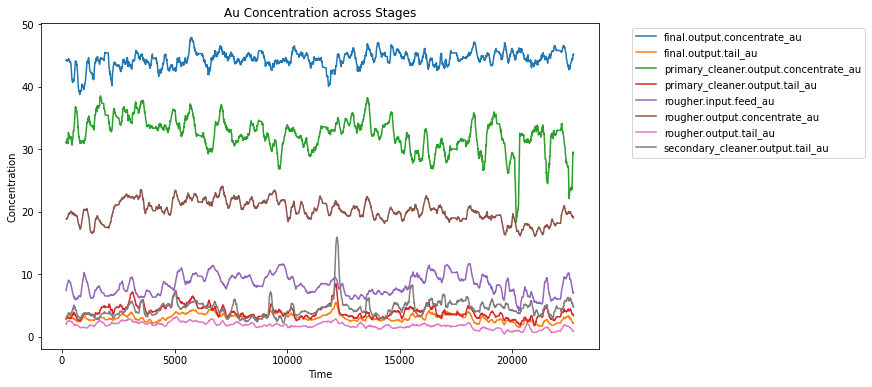

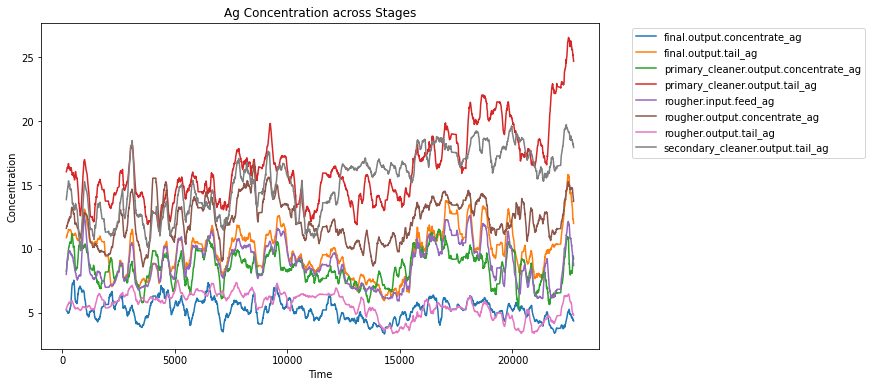

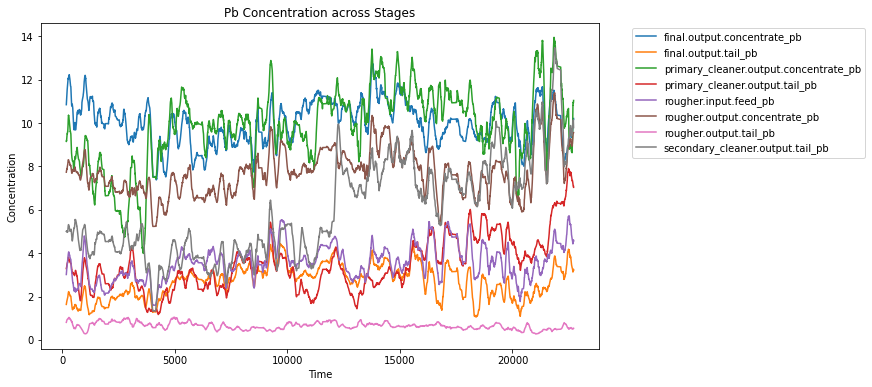

In [21]:
# Plot Au, Ag, and Pb concentrations across stages

# Window size of 150 is optimal
window_size = 150

# Use rolling mean with window size above to smoothen line plots
df_smoothed_au = df_au.rolling(window=window_size).mean()
df_smoothed_au.plot(kind='line', figsize=(10,6))
plt.title('Au Concentration across Stages')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

df_smoothed_ag = df_ag.rolling(window=window_size).mean()
df_smoothed_ag.plot(kind='line', figsize=(10,6))
plt.title('Ag Concentration across Stages')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

df_smoothed_pb = df_pb.rolling(window=window_size).mean()
df_smoothed_pb.plot(kind='line', figsize=(10,6))
plt.title('Pb Concentration across Stages')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Au concentration increases from around 8% in rougher input feed to around 45% in final output concentrate while Ag concentration decreases from 10% in rougher input feed to 5% in final output concentrate. Ag concentration is highest in primary and secondary cleaner output tails.
Pb concentration is around 4% in rougher input feed and increases to 10% in final output concentrate.

### Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

In [22]:
df_recovery_train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [23]:
df_recovery_test['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

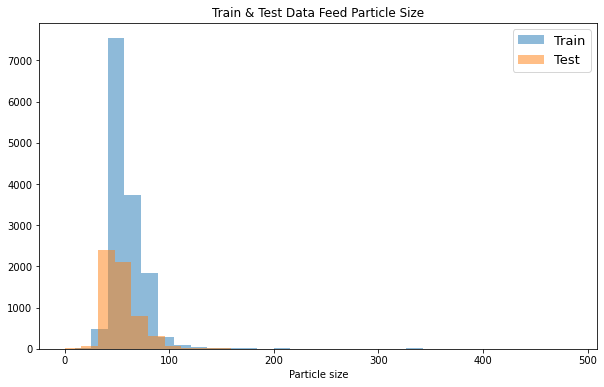

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(df_recovery_train['rougher.input.feed_size'], bins=30, alpha=0.5, label='Train')
plt.hist(df_recovery_test['rougher.input.feed_size'], bins=30, alpha=0.5, label='Test')
plt.legend(loc='upper right', prop={'size': 13})
plt.title('Train & Test Data Feed Particle Size')
plt.xlabel('Particle size')
plt.show()

Feed particle size distributions in train and test sets are similar. Mean & median values are only 4.5% and 8% different respectively.

### Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

In [25]:
#Create function to get total concentration of all metals at certain stages.
def metal_concen_sum(df, stage):
    metal_handles = ['au','ag','pb']
    total_concen = df[stage+'_'+metal_handles[0]] + df[stage+'_'+metal_handles[1]] + df[stage+'_'+metal_handles[2]]
    return total_concen

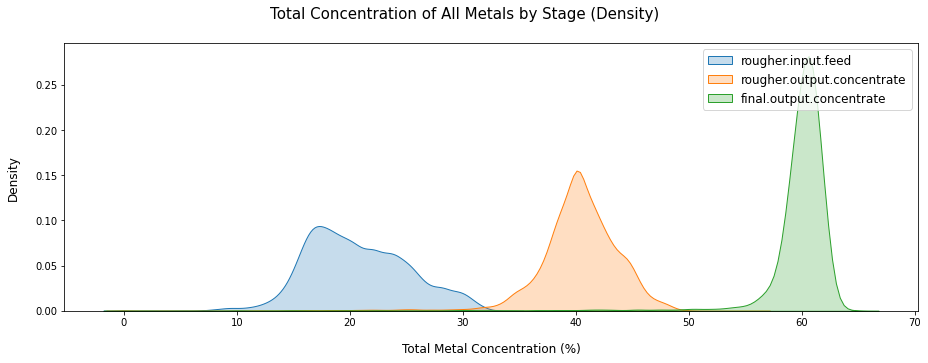

In [26]:
#Create plot to visualize total concentration of all metals at certain stages.
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(df_recovery_full, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(df_recovery_full, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(df_recovery_full, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

In [27]:
df_full_total_concentrations = pd.DataFrame()
df_full_total_concentrations['rougher_input_total_concentrations'] = df_recovery_full['rougher.input.feed_au'] + df_recovery_full['rougher.input.feed_ag'] + df_recovery_full['rougher.input.feed_pb']
df_full_total_concentrations['rougher_concentrate_total_concentrations'] = df_recovery_full['rougher.output.concentrate_au'] + df_recovery_full['rougher.output.concentrate_ag'] + df_recovery_full['rougher.output.concentrate_pb']
df_full_total_concentrations['final_concentrate_total_concentrations'] = df_recovery_full['final.output.concentrate_au'] + df_recovery_full['final.output.concentrate_ag'] + df_recovery_full['final.output.concentrate_pb']

df_full_total_concentrations[['rougher_input_total_concentrations', 'rougher_concentrate_total_concentrations', 'final_concentrate_total_concentrations']]

df_full_total_concentrations.describe()

,rougher_input_total_concentrations,rougher_concentrate_total_concentrations,final_concentrate_total_concentrations
count,19439.000000,19439.000000,19439.000000
mean,20.646120,40.186224,59.527111
std,4.480027,3.877308,4.402256
min,0.030000,0.030000,0.030000
25%,17.252879,38.569439,59.325195
50%,20.141216,40.312648,60.306921
75%,23.797381,42.365102,61.096667
max,33.498784,55.568687,64.968881


There are outliers in the total metal concentration distributions at raw feed, rougher concentrate, and final concentrate that should be removed from the training and test sets. Total metal concentration at raw feed stage should be higher than 8%, higher than 20% at rougher concentrate, and higher than 40% at final concentrate.

In [28]:
df_raw_feed_anomaly = df_recovery_full[metal_concen_sum(df_recovery_full, 'rougher.input.feed') < 8]['date']

In [29]:
df_rougher_concentrate_anomaly = df_recovery_full[metal_concen_sum(df_recovery_full, 'rougher.output.concentrate') < 20]['date']

In [30]:
df_final_concentrate_anomaly = df_recovery_full[metal_concen_sum(df_recovery_full, 'final.output.concentrate') < 40]['date']

In [31]:
# Combine rows from df_raw_feed_anomaly, df_rougher_concentrate_anomaly, and df_final_concentrate_anomaly and remove duplicates
df_anomalies = pd.concat([df_raw_feed_anomaly, df_rougher_concentrate_anomaly, df_final_concentrate_anomaly])

df_anomalies = df_anomalies.drop_duplicates()

df_anomalies

1403    2016-03-13 11:00:00
1404    2016-03-13 12:00:00
1574    2016-03-20 14:00:00
1755    2016-03-28 03:00:00
2328    2016-04-21 00:00:00
                ...        
22396   2018-08-05 03:59:59
22469   2018-08-08 04:59:59
22520   2018-08-10 07:59:59
22523   2018-08-10 10:59:59
22533   2018-08-10 20:59:59
Name: date, Length: 319, dtype: datetime64[ns]

In [32]:
# Remove anomalies from training data set
df_recovery_train = df_recovery_train[~df_recovery_train['date'].isin(df_anomalies)]
df_recovery_train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [33]:
# Remove anomalies from testing data set
df_recovery_test = df_recovery_test[~df_recovery_test['date'].isin(df_anomalies)]
df_recovery_test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


## Build the model

### Write a function to calculate the final sMAPE value.

In [34]:
# Generic function to calculate sMAPE for two lists of the same length
def smape(y_true, y_pred):
    total = 0
    for i in range(len(y_true)):   
            total += (np.abs(y_true[i] - y_pred[i])) / ((np.abs(y_true[i]) + np.abs(y_pred[i]))/2)           
    return total/len(y_true) * 100

# Function that uses smape() to calculate final sMAPE value from target & prediction values
def final_smape(target, predicted):
    target_rougher, target_final = target.iloc[:, 0].tolist(), target.iloc[:, 1].tolist()
    predicted_rougher, predicted_final = predicted[:, 0], predicted[:, 1]
    return 0.25 * smape(target_rougher, predicted_rougher) + 0.75*smape(target_final, predicted_final)

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [35]:
# Drop columns from df_recovery_train to match columns in df_recovery_test
features_train = df_recovery_train.drop(columns=column_difference_list + ['date'], axis=1)
target_train = df_recovery_train[['rougher.output.recovery', 'final.output.recovery']]

#features_test = df_recovery_test.drop(['date'], axis=1)
features_test = df_recovery_full[df_recovery_full['date'].isin(df_recovery_test['date'])].drop(columns=column_difference_list + ['date'], axis=1)
target_test = df_recovery_full[df_recovery_full['date'].isin(df_recovery_test['date'])][['rougher.output.recovery', 'final.output.recovery']]

### Linear Regression Model:

In [36]:
model = LinearRegression()

# Make a scorer from my final_smape() function
scorer = make_scorer(final_smape)

scores = cross_val_score(model, features_train, target_train, cv=5, scoring=scorer)

# Print the average score
print("Average final sMAPE score:", scores.mean())

Average final sMAPE score: 9.810544863420901


### Random Forest Model:

In [37]:
model = RandomForestRegressor(random_state=12345, n_estimators=10)

scores = cross_val_score(model, features_train, target_train, cv=5, scoring=scorer)

# Print the average score
print("Average final sMAPE score:", scores.mean())

Average final sMAPE score: 9.522844094378437


In [38]:
# Hyperparameter Tuning:
for est in range(15, 20): # choose hyperparameter range
    model = RandomForestRegressor(random_state=12345, n_estimators=est) # set number of trees
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring=scorer)
    print('n_estimators =', est, "average final sMAPE score:", scores.mean())

n_estimators = 15 average final sMAPE score: 9.480593782860225
n_estimators = 16 average final sMAPE score: 9.4053731884464
n_estimators = 17 average final sMAPE score: 9.345702297538248
n_estimators = 18 average final sMAPE score: 9.37102440280885
n_estimators = 19 average final sMAPE score: 9.317301022035707


This tuning process combined with cross-validation is computationally intensive, so the range of n_estimators is kept small. Random Forest Regressor with 19 n_estimators achieved the lowest average final sMAPE score of 9.31

### Decision Tree Model:

In [39]:
model = DecisionTreeRegressor(random_state=12345)

scores = cross_val_score(model, features_train, target_train, cv=5, scoring=scorer)

# Print the average score
print("Average final sMAPE score:", scores.mean())

Average final sMAPE score: 13.615343138859222


In [40]:
# Hyperparameter Tuning:
for depth in range(1,10):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring=scorer)
    print('max_depth =', depth, "average final sMAPE score:", scores.mean())

max_depth = 1 average final sMAPE score: 9.229845894036952
max_depth = 2 average final sMAPE score: 9.153057420322254
max_depth = 3 average final sMAPE score: 8.90892435402286
max_depth = 4 average final sMAPE score: 9.050385212238215
max_depth = 5 average final sMAPE score: 9.291546173940791
max_depth = 6 average final sMAPE score: 9.485779017736713
max_depth = 7 average final sMAPE score: 11.016088531939433
max_depth = 8 average final sMAPE score: 10.524832027921544
max_depth = 9 average final sMAPE score: 10.84029163254161


Decision Tree Regressor with a max depth of 3 achieved the lowest average final sMAPE score of 8.9

### Testing Best Model

In [41]:
# Decision Tree Regressor with a max depth of 3
best_model = DecisionTreeRegressor(random_state=12345, max_depth=3)

scores = cross_val_score(best_model, features_train, target_train, cv=5, scoring=scorer)

# Print the average score
print("Average final sMAPE score:", scores.mean())

Average final sMAPE score: 8.90892435402286


In [42]:
best_model = DecisionTreeRegressor(random_state=12345, max_depth=3)
best_model.fit(features_train,target_train)
predicted_test = best_model.predict(features_test)

final_smape(target_test,predicted_test)

7.263904366990728

In [43]:
# Sanity Check using mean DummyRegressor
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(features_train, target_train)
dummy_predictions = dummy_reg.predict(features_test)
final_smape(target_test,dummy_predictions)

7.545599135696535

Final sMAPE score for test data is 7.26 using the tuned Decision Tree Regressor model, which is better than model that always predicts the mean.

## Conclusions:

- Decision Tree Regressor model with max depth of 3 is best for this task
- Given a dataset with particle feed size similar to trained data (47 to 65), model can predict rougher & finaly recovery values with an acceptable final sMAPE value